# Constrained Shape Optimization on inductance

We will allow the red boundary (frontier) to move freely, rather than being constrained by predefined parameters. Furthermore, we will allow the vertical segments connected to the red frontier to shift freely in the vertical direction, providing additional flexibility in the design.

We minimize the magnetic energy within the conductor region while constraining the inductance. To achieve this, we use the augmented Lagrangian algorithm, aiming to reduce losses.

In [1]:
# donner un pipfile pour la config

from commonSG import create_plots, update_plots, rot  # noqa: F401
import ngsolve as ngs
from ngsolve.webgui import Draw
from netgen.geom2d import CSG2d, Rectangle
from netgen.geom2d import EdgeInfo as EI, PointInfo as PI, Solid2d
import numpy as np
import matplotlib.pyplot as plt


## 1 - Meshing

In [ ]:
from netgen.geom2d import SplineGeometry


# Global domain
r = 0.04

# Geometry definition
e = 5e-3
a = 1e-2
ha = 1e-2
ba = 1e-2
d = 1e-2



def gen_mesh(air_gap, maxh=7e-4, debug=False):
    """Gives a triangular mesh"""
    geo = SplineGeometry()
    pnts = [
        (0, air_gap / 2),  # p1
        (a / 2, air_gap / 2),  # p2
        (a / 2, e / 2 + ha / 2),  # p3
        (a / 2 + ba, e / 2 + ha / 2),  # p4
        (a / 2 + ba, air_gap / 2),  # p5
        (a + ba, air_gap / 2),  # p6
        (a + ba, e / 2 + ha / 2 + a / 2),  # p7
        (0, e / 2 + ha / 2 + a / 2),  # p8
        (a + ba, 0),  # p001
        (a + ba, e / 2 + ha / 2),  # p002
        (0, e / 2 + ha / 2),  # p003
        (0, 0),  # p00
        (r, 0),  # p01
        (0, r),  # p02
        (a / 2, 0),  # p03
        (a / 2 + ba, 0),  # p04
        (r, r),  # p05
    ]

    (
        p1,
        p2,
        p3,
        p4,
        p5,
        p6,
        p7,
        p8,
        p001,
        p002,
        p003,
        p00,
        p01,
        p02,
        p03,
        p04,
        p05,
    ) = [geo.AppendPoint(*pnt) for pnt in pnts]

    # List of lines with boundary conditions and domains
    lines = [
        [["line", p1, p2], {"bc": "front", "leftdomain": 2, "rightdomain": 4}],
        [["line", p2, p3], {"bc": "optimVert", "leftdomain": 2, "rightdomain": 3}],
        [["line", p3, p4], {"bc": "default", "leftdomain": 2, "rightdomain": 3}],
        [["line", p4, p5], {"bc": "optimVert", "leftdomain": 2, "rightdomain": 3}],
        [["line", p5, p6], {"bc": "front", "leftdomain": 2, "rightdomain": 1}],
        [["line", p6, p002], {"bc": "front", "leftdomain": 2, "rightdomain": 1}],
        [["line", p002, p7], {"bc": "front", "leftdomain": 2, "rightdomain": 1}],
        [["line", p7, p8], {"bc": "front", "leftdomain": 2, "rightdomain": 1}],
        [["line", p00, p03], {"bc": "domainHor", "leftdomain": 4, "rightdomain": 0}],
        [["line", p03, p04], {"bc": "segment1", "leftdomain": 3, "rightdomain": 0}],
        [["line", p04, p001], {"bc": "domainHor", "leftdomain": 1, "rightdomain": 0}],
        [["line", p001, p01], {"bc": "segment1", "leftdomain": 1, "rightdomain": 0}],
        [["line", p02, p8], {"bc": "segment2", "leftdomain": 1, "rightdomain": 0}],
        [["line", p8, p003], {"bc": "optimVert", "leftdomain": 2, "rightdomain": 0}],
        [["line", p003, p1], {"bc": "domainVert", "leftdomain": 2, "rightdomain": 0}],
        [["line", p1, p00], {"bc": "domainVert", "leftdomain": 4, "rightdomain": 0}],
        [["line", p04, p5], {"bc": "optimVert", "leftdomain": 3, "rightdomain": 1}],
        [["line", p2, p03], {"bc": "optimVert", "leftdomain": 3, "rightdomain": 4}],
        [["spline3", p01, p05, p02], {"bc": "arc", "leftdomain": 1, "rightdomain": 0}],
    ]

    # Append all lines to the geometry
    for line, props in lines:
        geo.Append(line, **props)

    # Debugging with matplotlib
    if debug:
        line_labels_offset = 6e-4
        debug_geometry(geo, line_labels_offset)

    # Set materials and meshing parameters
    geo.SetMaterial(1, "air")
    geo.SetMaterial(2, "core")
    geo.SetMaterial(3, "coil")
    geo.SetMaterial(4, "air")
    ngmesh = geo.GenerateMesh(maxh=maxh)
    return ngs.Mesh(ngmesh)




# XiAir = ngs.CoefficientFunction([1, 0, 0, 0, 0, 1, 1])
# XiCore = ngs.CoefficientFunction([0, 1, 0, 1, 1, 0, 0])
# XiCoil = ngs.CoefficientFunction([0, 0, 1, 0, 0, 0, 0])

XiAir = ngs.CoefficientFunction([1, 0, 0, 1])
XiCore = ngs.CoefficientFunction([0, 1, 0, 0])
XiCoil = ngs.CoefficientFunction([0, 0, 1, 0])

maxh = 5e-4
air_gap = 4e-3
mesh = gen_mesh(air_gap, maxh, debug=False)

Draw(1 * XiAir + 2 * XiCoil + 3 * XiCore, mesh, radius=0.02)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 2 - Computation of cost function and state (magnetostatic potential)

In [3]:
L_target = 1e-3

mu0 = 4e-7 * np.pi
mur = 1000
mu_iron = mur * mu0
mu_coil = (0.9 - 0.1j) * mu0  #  AC losses in the copper from the imaginary part of the permeability
# mu_coil = (1 - 0.0j) * mu0
omega = 2 * np.pi * 5e4

coeff_losses = 4 * d * omega * (1 / mu_coil).imag
# coeff_losses = 4 * d * omega * (1 / mu_coil).real

nb_turn = 200  # Number of turn in the coil
Is = 2  # Source current intensity
js = nb_turn * Is / (ba * (e + ha)) * XiCoil  # Source current density


def Inductance(a, mesh):
    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    return ngs.Integrate(2 * 4 * d * 0.5 * rel * ngs.InnerProduct(ngs.grad(a), ngs.grad(a)) / (Is * Is), mesh).real


def Constraint(a, mesh):
    return Inductance(a, mesh) - L_target


def Losses(a, mesh):
    return ngs.Integrate(coeff_losses * ngs.InnerProduct(ngs.grad(a), ngs.grad(a)) * ngs.dx("coil"), mesh).real


def CostFunction(a, l, b, constraint, mesh):
    return (Losses(a, mesh) + l * constraint + 0.5 * b * constraint**2).real


def EnergyCoil(a, mesh):
    """Magnetic energy in the coil domain"""
    return ngs.Integrate(
        4 * d * 0.5 * (1 / mu_coil) * ngs.InnerProduct(ngs.grad(a), ngs.grad(a)) * ngs.dx("coil"), mesh
    ).real


# Alternative model for loss (based on magnetic energy)
# coeff_losses = 2 * d * (1 / mu_coil)
# mu_coil = (1 - 0.0j) * mu0

# Losses = EnergyCoil

# def CostFunction(a, l, b, constraint, mesh):
#     return (Losses(a, mesh) + l * constraint + 0.5 * b * constraint**2).real


In [4]:
def magWeakFormComplex(a, a_):
    bf = ngs.grad(a_) * 1 / mu_iron * ngs.grad(a) * ngs.dx("core")
    bf += ngs.grad(a_) * 1 / mu_coil * ngs.grad(a) * ngs.dx("coil")
    bf += ngs.grad(a_) * 1 / mu0 * ngs.grad(a) * ngs.dx("air")
    lf = a_ * js * ngs.dx("coil")
    return bf, lf


def solveStateComplex(fes):
    a, a_ = fes.TnT()
    bf, f = magWeakFormComplex(a, a_)
    K, F = ngs.BilinearForm(fes), ngs.LinearForm(fes)
    K += bf
    F += f
    K.Assemble()
    F.Assemble()
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")  # Hermitian ?
    gf.vec.data = Kinv * F.vec
    return gf, Kinv


In [5]:
mesh = gen_mesh(air_gap=4e-3, maxh=5e-4, debug=False)
# mesh = ngs.Mesh("4_optimized_mesh.vol") # Decomment to get optimized shape

# Draw(1 * XiAir + 2 * XiCoil + 3 * XiCore, mesh, radius=0.02)

# from mmglib import run_adapt, copy_ngmesh

# new_ngmesh, return_code = run_adapt(mesh.ngmesh, hausd=1e-6, hmax=2e-3)
# mesh = ngs.Mesh(new_ngmesh)
# Draw(1 * XiAir + 2 * XiCoil + 3 * XiCore, mesh, radius=0.02)

fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
VEC_complex = ngs.VectorH1(mesh, complex=True)
VEC_real = ngs.VectorH1(mesh)

state, Kinv = solveStateComplex(fes)

print(f"The inductance is {1e3 * np.absolute(Inductance(state, mesh)):.3f} mH")
print(f"The magnetic energic inside the coil is {1e3*EnergyCoil(state, mesh):.3f} mJ")
print(f"The losses amounts to {Losses(state, mesh):.3f} W")

Draw(state, radius=0.009, center=(a / 2 + ba / 2, (e + ha + a) / 4))
Draw(ngs.Norm(rot(state)), mesh, radius=0.009, center=(a / 2 + ba / 2, (e + ha + a) / 4))


The inductance is 0.999 mH
The magnetic energic inside the coil is 0.378 mJ
The losses amounts to 26.415 W


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 3 - Compute adjoint states and shape derivatives

In [6]:
def solveAdjointLosses(a0, Kinv):
    """Solves the adjoint equation for the losses inside the coil"""
    fes = a0.space
    p, p_ = fes.TnT()
    f = ngs.LinearForm(fes)
    f += -2 * coeff_losses * ngs.InnerProduct(ngs.grad(a0), ngs.grad(p_)) * ngs.dx("coil")
    f.Assemble()
    gf = ngs.GridFunction(fes)
    gf.vec.data = Kinv.H * f.vec
    return gf


def solveAdjointInductance(state, Kinv):
    """Solves the adjoint equation for the inductance"""
    fes = state.space
    v = fes.TestFunction()
    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    F = ngs.LinearForm(fes)
    F += -8 * d * rel / (Is * Is) * ngs.InnerProduct(ngs.grad(state), ngs.grad(v)) * ngs.dx
    F.Assemble()
    gfu = ngs.GridFunction(fes)
    gfu.vec.data = Kinv * F.vec
    return gfu


def computeLossesShapeDerivative(VEC_complex, VEC_real, a0, p0):
    """Shape derivative for the complex losses inside the coil"""
    X = VEC_complex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix

    dLOmega = ngs.LinearForm(VEC_complex)
    dLOmega += ngs.SymbolicLFI(coeff_losses * XiCoil * ngs.InnerProduct((ngs.grad(a0)), ngs.grad(a0)) * ngs.div(X))
    dLOmega += ngs.SymbolicLFI(-2 * coeff_losses * XiCoil * ngs.InnerProduct(ngs.grad(X) * ngs.grad(a0), ngs.grad(a0)))
    dLOmega += ngs.SymbolicLFI(-js * XiCoil * ngs.div(X) * p0)  # div(js X) = div(X)js + X * grad(js) = div(X)js a.e.
    dLOmega += ngs.SymbolicLFI(
        ngs.InnerProduct(rel * (ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans) * ngs.grad(a0), ngs.grad(p0))
    )

    dLOmega.Assemble()
    dJ = ngs.GridFunction(VEC_real)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


# With this shape derivative, the optimization works like before !
def computeLossesShapeDerivative(VEC_complex, VEC_real, a0, p0):
    """Shape derivative for the energy-based losses inside the coil"""
    X = VEC_complex.TestFunction()

    coeff_losses = 2 * d * (1 / mu_coil)  # Different coefficient, same formula
    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix

    dLOmega = ngs.LinearForm(VEC_complex)
    dLOmega += coeff_losses * ngs.InnerProduct((ngs.grad(a0)), ngs.grad(a0)) * ngs.div(X) * ngs.dx("coil")
    dLOmega += -2 * coeff_losses * XiCoil * ngs.InnerProduct(ngs.grad(X) * ngs.grad(a0), ngs.grad(a0)) * ngs.dx("coil")
    dLOmega += -js * XiCoil * ngs.div(X) * p0 * ngs.dx  # div(js X) = div(X)js + X * grad(js) = div(X)js a.e.
    dLOmega += (
        ngs.InnerProduct(rel * (ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans) * ngs.grad(a0), ngs.grad(p0))
        * ngs.dx
    )

    dLOmega.Assemble()
    dJ = ngs.GridFunction(VEC_real)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


def computeInductanceShapeDerivative(VEC_complex, VEC_real, a0, p0):
    """Shape derivative for the inductance"""
    X = VEC_complex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix

    dLOmega = ngs.LinearForm(VEC_complex)
    dLOmega += -2 * 4 * d * rel / (Is * Is) * ngs.InnerProduct(ngs.grad(X) * ngs.grad(a0), ngs.grad(a0)) * ngs.dx
    dLOmega += 4 * d * rel / (Is * Is) * ngs.InnerProduct(ngs.grad(a0), ngs.grad(a0)) * ngs.div(X) * ngs.dx
    dLOmega += -js * ngs.div(X) * p0 * ngs.dx  # div(js X) = div(X)js + X * grad(js) = div(X)js a.e.
    dLOmega += (
        ngs.InnerProduct(rel * (ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans) * ngs.grad(a0), ngs.grad(p0))
        * ngs.dx
    )
    dLOmega.Assemble()

    dJ = ngs.GridFunction(VEC_real)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


def computeShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_losses, adjoint_inductance, l, b):
    """Shape derivative for the cost function"""
    dJOmegaInductance = computeInductanceShapeDerivative(VEC_complex, VEC_real, state, adjoint_inductance)
    constraint = Constraint(state, mesh)
    dJOmega = computeLossesShapeDerivative(VEC_complex, VEC_real, state, adjoint_losses)
    dJOmega.vec.FV().NumPy()[:] += l * dJOmegaInductance.vec.FV().NumPy()[:]
    dJOmega.vec.FV().NumPy()[:] += b * constraint * dJOmegaInductance.vec.FV().NumPy()[:]
    return dJOmega


In [7]:
mesh = gen_mesh(air_gap=4e-3, maxh=5e-4, debug=False)
# mesh = ngs.Mesh("4_optimized_mesh.vol") # Decomment to get optimized shape

fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
VEC_complex = ngs.VectorH1(mesh, complex=True)
VEC_real = ngs.VectorH1(mesh)

state, Kinv = solveStateComplex(fes)  # Is a GridFunction (field approximated on a fes)
adjoint_losses = solveAdjointLosses(state, Kinv)
adjoint_inductance = solveAdjointInductance(state, Kinv)

dJOmega = computeShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_losses, adjoint_inductance, 1, 1)

# Draw(state, radius=0.009, center=(a / 2 + ba / 2, (e + ha + a) / 4))
# Draw(ngs.Norm(rot(state)), mesh, radius=0.009, center=(a / 2 + ba / 2, (e + ha + a) / 4))
Draw(adjoint_inductance, radius=0.009, center=(a / 2 + ba / 2, (e + ha + a) / 4))
Draw(
    adjoint_losses.real, mesh, radius=0.009, center=(a / 2 + ba / 2, (e + ha + a) / 4)
)  # Note that the imag part should be 0


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 4 - Computation of the descent direction

In [8]:
def SolveDeformationEquation(mesh, fX):
    VEC = ngs.VectorH1(
        mesh,
        order=1,
        dirichlet="arc|segment1|segment2|default",
        dirichlety="optimHor|domainHor",
        dirichletx="optimVert|domainVert",
        definedon=mesh.Materials("core|air"),
    )
    PHI, X = VEC.TnT()

    # H1 dot product
    # B = ngs.BilinearForm(VEC)
    # B += ngs.InnerProduct(ngs.grad(X), ngs.grad(PHI)) * ngs.dx + ngs.InnerProduct(X, PHI) * ngs.dx
    # B.Assemble()

    # Linear elasticity-type dot product (maybe try with lame parameter ?)
    B = ngs.BilinearForm(VEC)
    B += (
        ngs.InnerProduct(0.5 * (ngs.grad(X) + ngs.grad(X).trans), ngs.grad(PHI)) * ngs.dx
        + ngs.InnerProduct(X, PHI) * ngs.dx
    )
    B.Assemble()

    gfX = ngs.GridFunction(VEC)
    gfX.vec.data = -B.mat.Inverse(VEC.FreeDofs()) * fX.vec
    return gfX


# Without dirichlet conditions
dJ = ngs.GridFunction(VEC_real)
dJ.vec.FV().NumPy()[:] = dJOmega.vec.FV().NumPy()[:]
Draw(dJ, mesh, vectors={"grid_size": 40}, radius=0.009, center=(a / 2 + ba / 2, (e + ha + a) / 4))

# With dirichlet conditions
descent_direction = SolveDeformationEquation(mesh, dJ)
# descent_direction.vec.FV().NumPy()[: (VEC_real.ndof // 2)] = np.zeros(VEC_real.ndof // 2)  # Cancel x coordinate
Draw(descent_direction.real, mesh, vectors={"grid_size": 40}, radius=0.009, center=(a / 2 + ba / 2, (e + ha + a) / 4))


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 5 - Testing mesh adaptation with mmg

In [9]:
# Initializations
mesh = gen_mesh(air_gap=4e-3, maxh=7e-4, debug=False)
fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
VEC_complex = ngs.VectorH1(mesh, complex=True)
VEC_real = ngs.VectorH1(mesh)

l = 1e-2
b = 1e-1

# State and cost function
state, Kinv = solveStateComplex(fes)
constraint = Constraint(state, mesh)
Jold = CostFunction(state, l, b, constraint, mesh)

# Adjoints, shape derivate then descent direction
adjoint_losses = solveAdjointLosses(state, Kinv)
adjoint_inductance = solveAdjointInductance(state, Kinv)
dJOmega = computeShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_losses, adjoint_inductance, 1, 1)

descent_direction = SolveDeformationEquation(mesh, dJOmega)
currentNorm = ngs.Norm(descent_direction.vec)
derivative = ngs.InnerProduct(dJOmega.vec, descent_direction.vec)

if derivative > 0:
    raise ValueError("derivative positive :(")


def move_ngmesh_2D(displ, mesh):
    mat_displ = displ.vec.FV().NumPy()
    nb_points = len(mat_displ) // 2
    for i, point in enumerate(mesh.ngmesh.Points()):
        vx = mat_displ[i]
        vy = mat_displ[i + nb_points]
        point[0] += vx
        point[1] += vy
    mesh.ngmesh.Update()


from mmglib import run_adapt, copy_ngmesh

# print("Initial mesh")
# state, Kinv = solveStateComplex(fes)
# Draw(ngs.Norm(rot(state)), mesh)

# print("copy of Initial mesh")
# copied_ngmesh = copy_ngmesh(mesh.ngmesh)
# copied_mesh = ngs.Mesh(copied_ngmesh)
# Draw(ngs.Norm(rot(state)), copied_mesh)

print("Moved mesh")
descent_direction.vec.data = 3e-7 * descent_direction.vec
move_ngmesh_2D(descent_direction, mesh)
# mesh.ngmesh.OptimizeMesh2d() # Does not work

# Test the descent of the cost
fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
state, Kinv = solveStateComplex(fes)
constraint = Constraint(state, mesh)
Jnew = CostFunction(state, l, b, constraint, mesh)

if Jnew < Jold:
    print("J decreased")
else:
    print("J increased")
Draw(ngs.Norm(rot(state)), mesh)

# print("copy of Initial mesh")
# Draw(ngs.Norm(rot(state)), copied_mesh)

print("Optimized moved mesh")
new_ngmesh, return_code = run_adapt(mesh.ngmesh, hausd=3e-6, hmax=2e-3)
new_mesh = ngs.Mesh(new_ngmesh)
fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
state, Kinv = solveStateComplex(fes)
Draw(ngs.Norm(rot(state)), new_mesh)

# print("Recover initial mesh")
# descent_direction.vec.data = -descent_direction.vec
# move_ngmesh_2D(descent_direction, mesh)
# fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
# state, tangent_matrix = solveStateComplex(fes)
# Draw(ngs.Norm(rot(state)), mesh)


Moved mesh
J decreased


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Optimized moved mesh
BAD ENDING OF MMG2DLIB


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 4 - Optimization loop


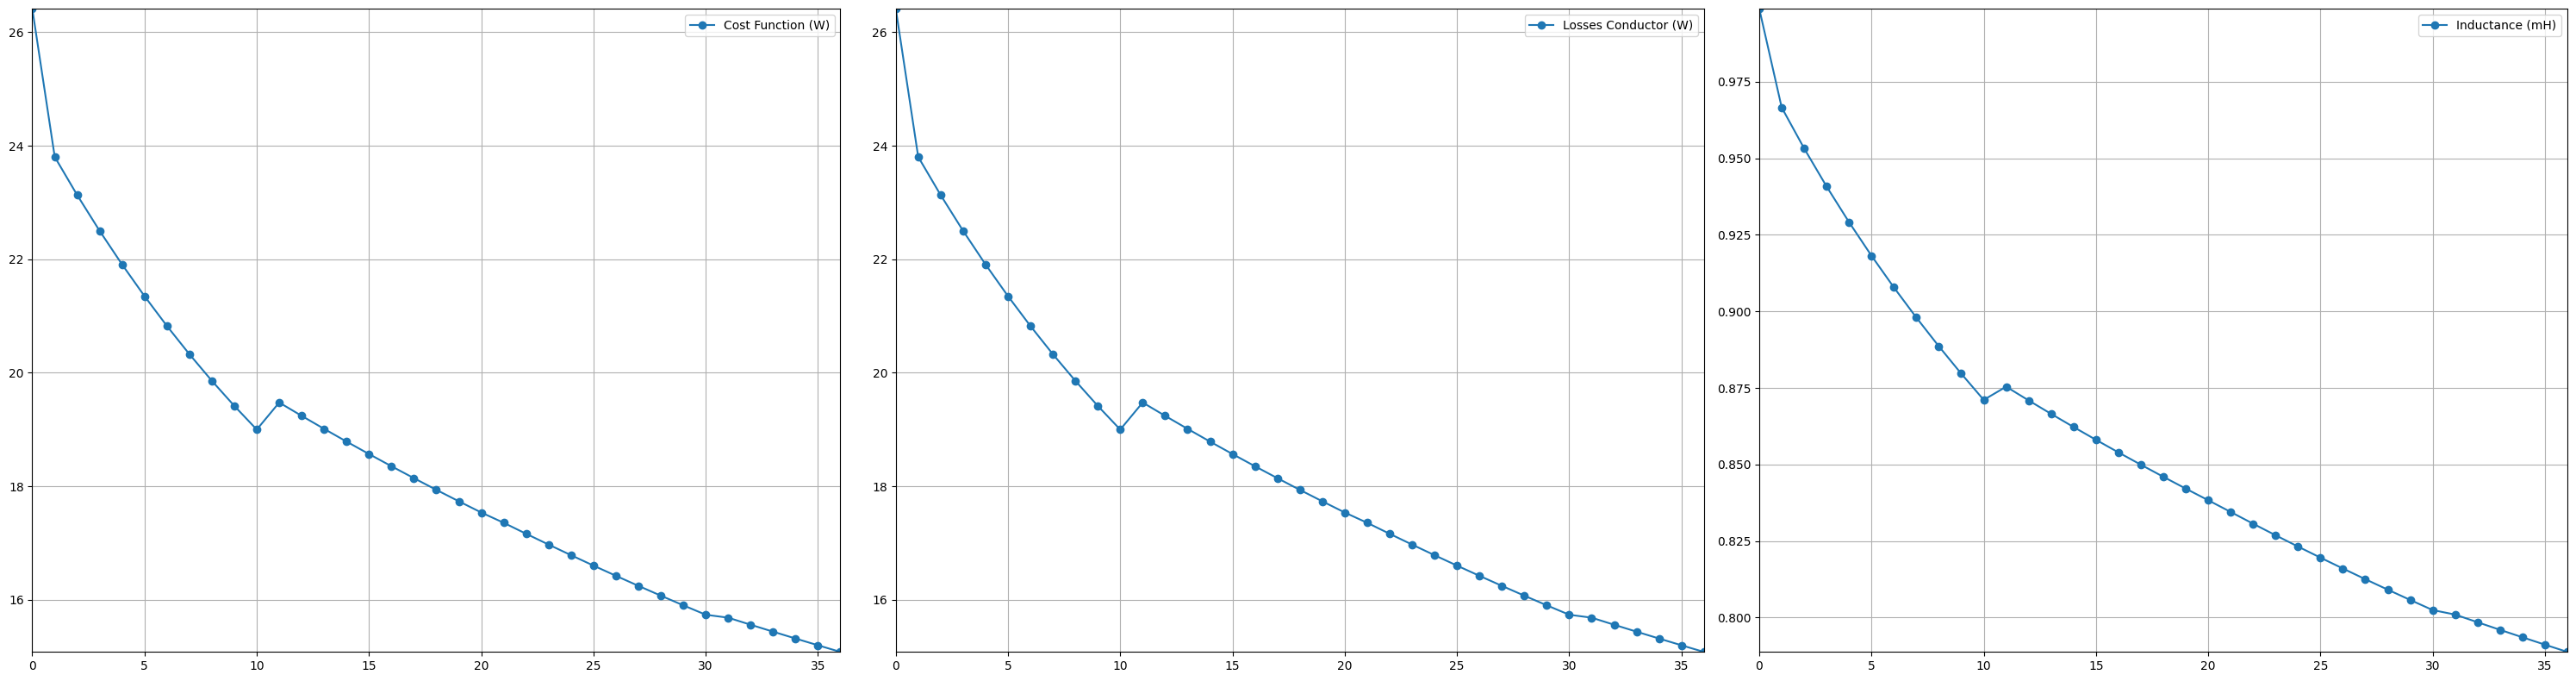

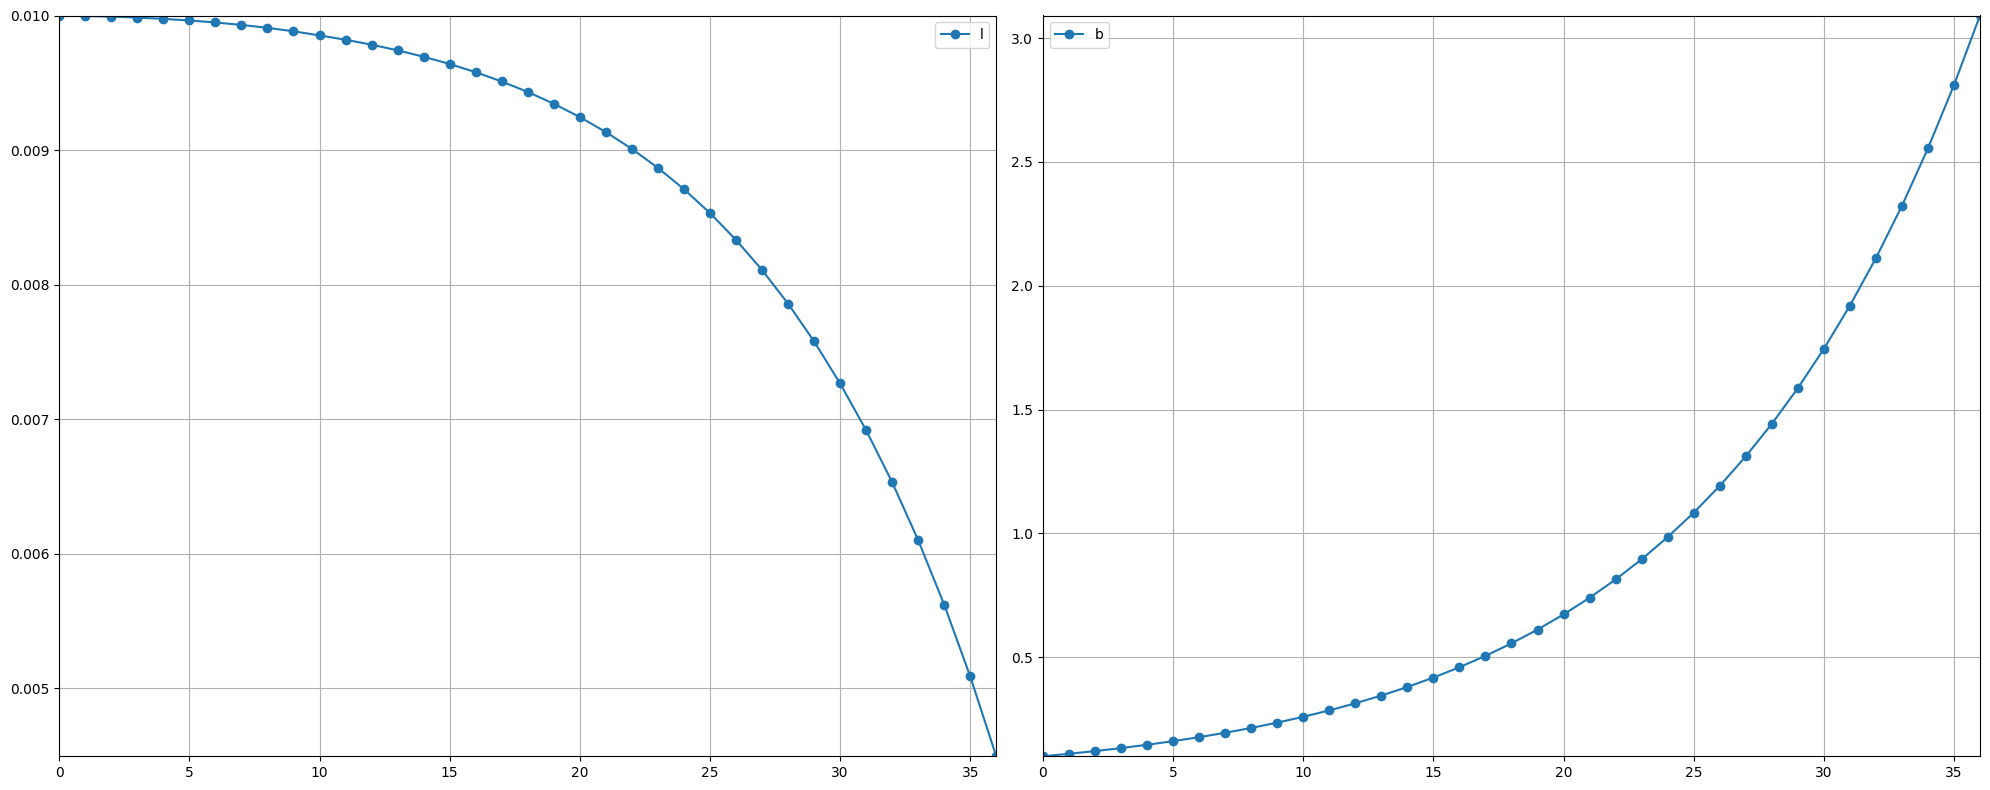

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

c:\Users\theodore\Documents\GitHub\inductance-compumag\notebooks\commonSG.py:37: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, len(curve) - 1)
c:\Users\theodore\Documents\GitHub\inductance-compumag\notebooks\commonSG.py:40: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(min_y, max_y)


KeyboardInterrupt: 

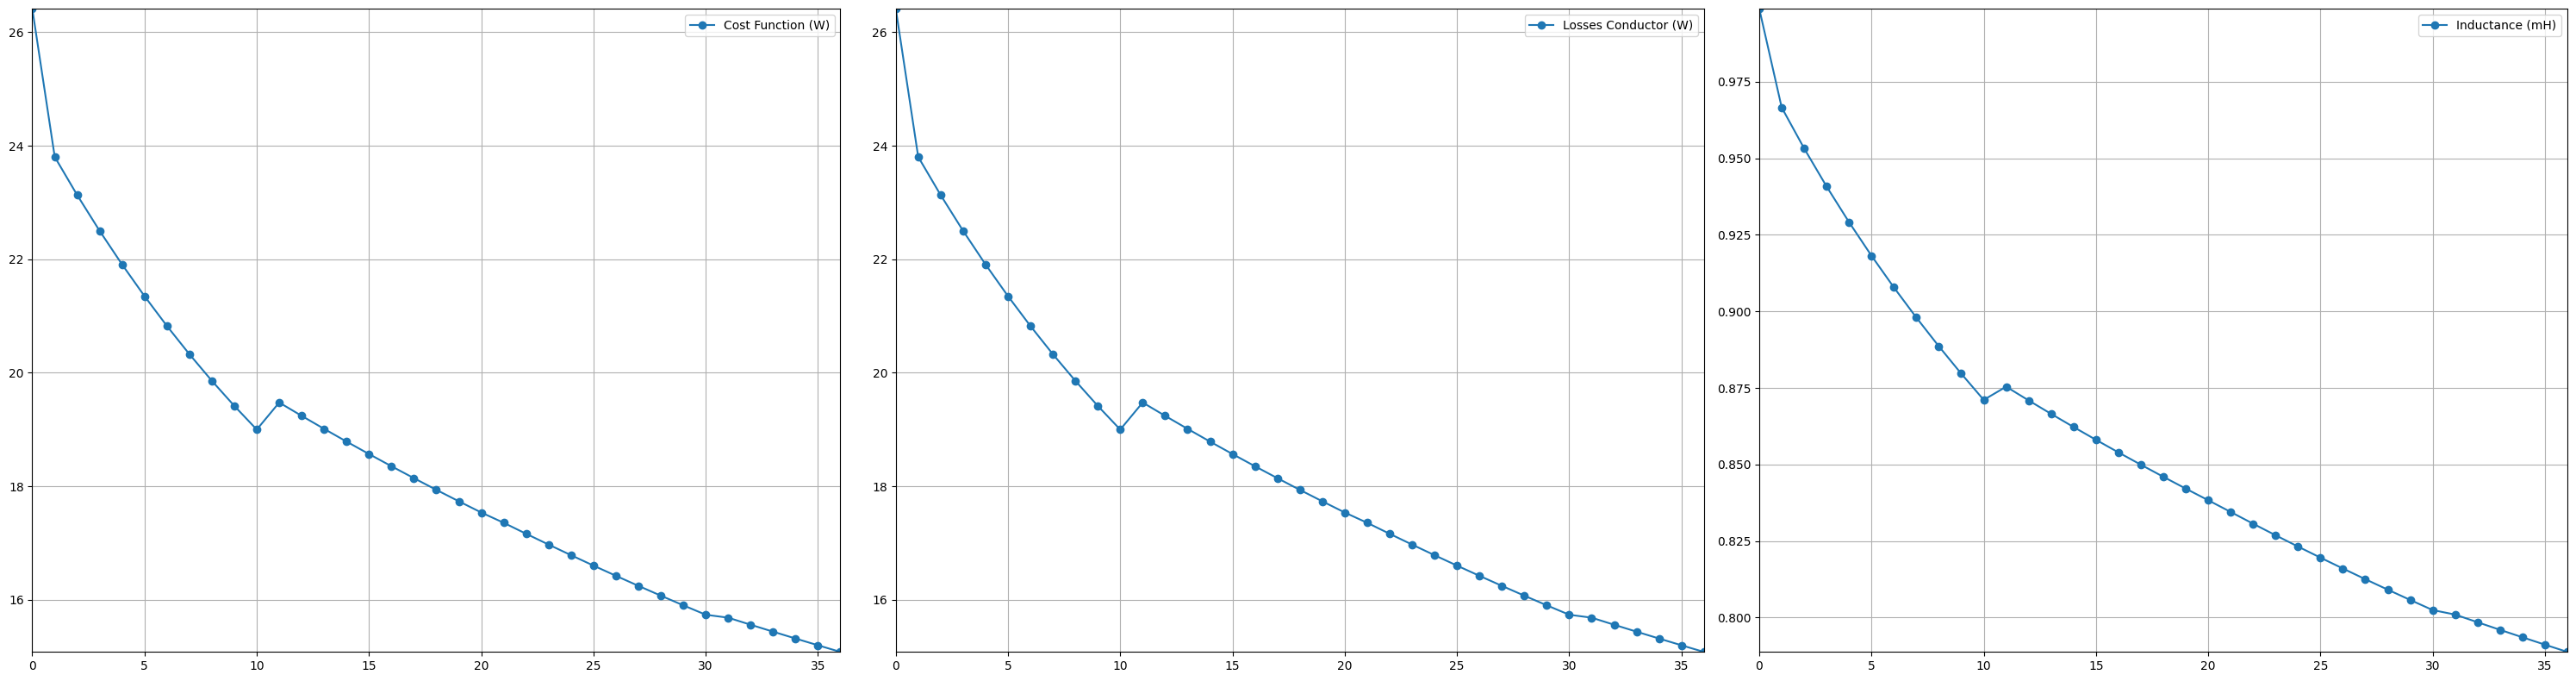

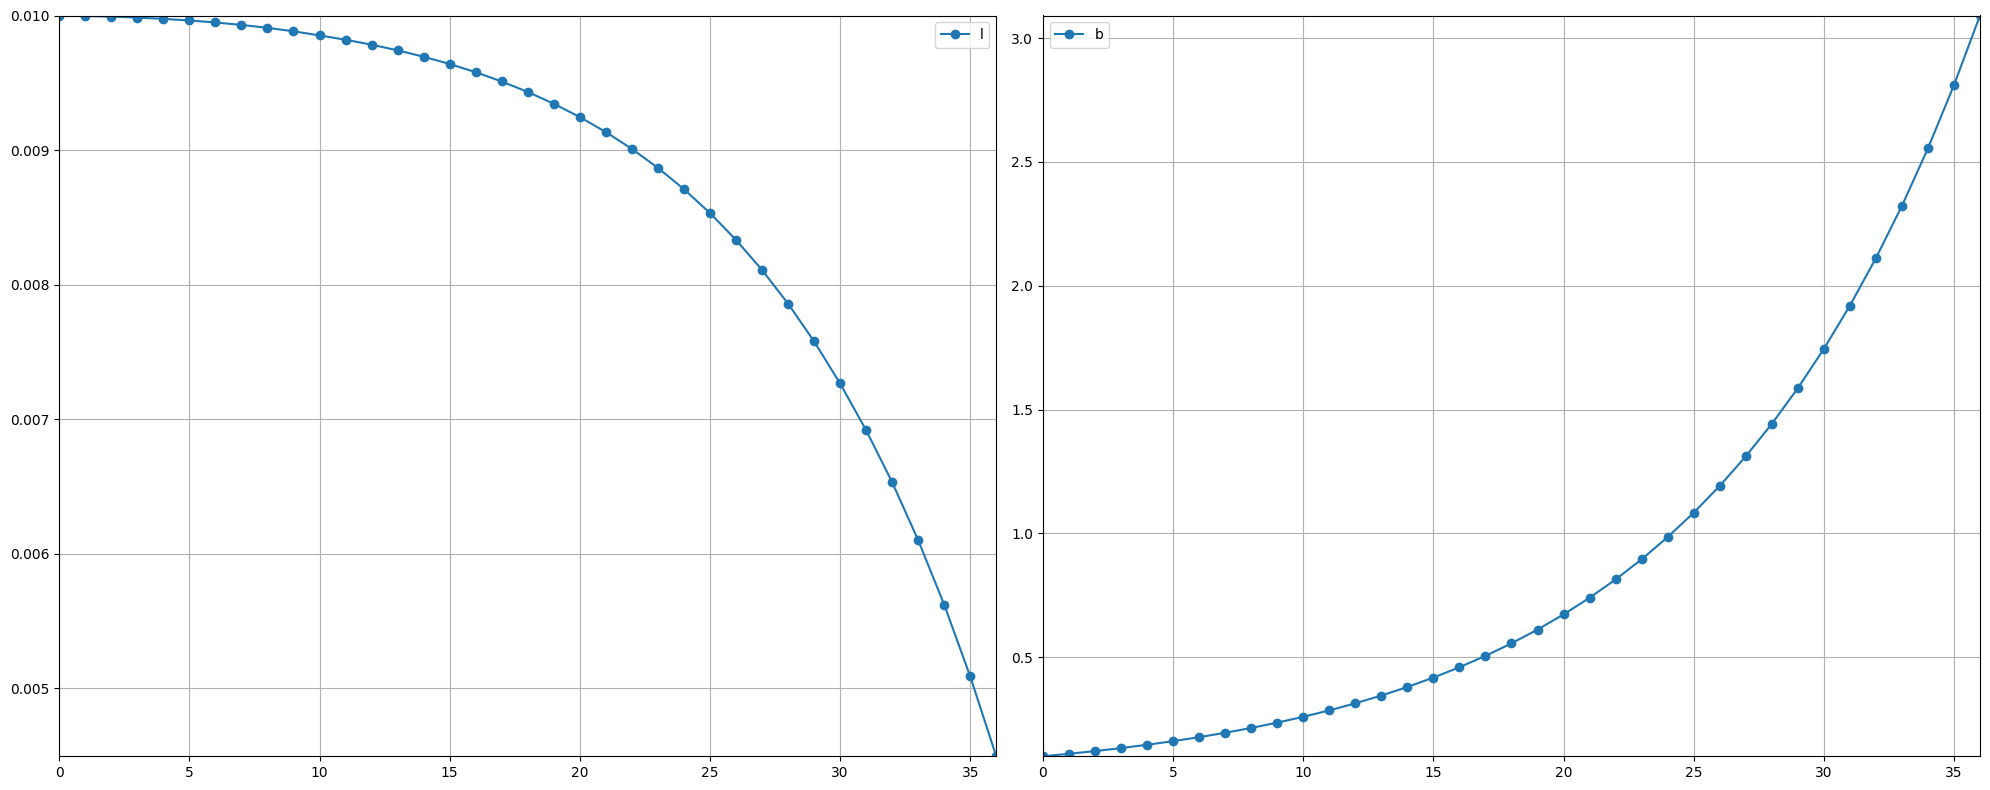

In [10]:
# Initialize geometry
mesh = gen_mesh(air_gap=4e-3, maxh=5e-4, debug=False)
# mesh = ngs.Mesh("4_optimized_mesh.vol")

fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
VEC_complex = ngs.VectorH1(mesh, order=1, complex=True)
VEC_real = ngs.VectorH1(mesh, order=1)

# Initialize data arrays and plots
costs = []
energies = []
inductances = []
num_plots = 3
fig, axes, hdisplay = create_plots(num_plots)
curve_labels = [
    ["Cost Function (W)"],
    ["Losses Conductor (W)"],
    ["Inductance (mH)"],
]

l_values = []
b_values = []
num_plots = 2
figBis, axesBis, hdisplayBis = create_plots(num_plots)
curve_labels_bis = [
    ["l"],
    ["b"],
]

scene = Draw(ngs.Norm(rot(state)), mesh, radius=0.0001, center=(0, 0))

# Algorithmic parameters
iter_max = 2000
converged = False
iter = 0
minstep = 1e-10
maxstep = 0.5
step = maxstep
eps = 1e-10

# Augmented Lagragian parameters
l = 1e-2
b = 1e-1
btarget = 1e6

# Initializing state, adjoints, cost function
state, Kinv = solveStateComplex(fes)  # Is a GridFunction (field approximated on a fes)
adjoint_losses = solveAdjointLosses(state, Kinv)
adjoint_inductance = solveAdjointInductance(state, Kinv)
dJOmega = computeShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_losses, adjoint_inductance, l, b)
constraint = Constraint(state, mesh)
Jnew = CostFunction(state, l, b, constraint, mesh)

# Optimization loop
while not converged and iter < iter_max:
    # Step 1: Update fespace
    fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
    VEC_complex = ngs.VectorH1(mesh, order=1, complex=True)
    VEC_real = ngs.VectorH1(mesh, order=1)

    # Step 2: Update the state and adjoint state
    state, Kinv = solveStateComplex(fes)  # Is a GridFunction (field approximated on a fes)
    adjoint_losses = solveAdjointLosses(state, Kinv)
    adjoint_inductance = solveAdjointInductance(state, Kinv)

    constraintold = Constraint(state, mesh)
    Jold = CostFunction(state, l, b, constraintold, mesh)

    # Step 2.5: Update the data arrays
    costs.append(Jold)
    energies.append(Losses(state, mesh))
    inductances.append(1e3 * Inductance(state, mesh))
    data = [
        [costs],
        [energies],
        [inductances],
    ]
    update_plots(fig, axes, hdisplay, data, curve_labels)

    l_values.append(l)
    b_values.append(b)
    data = [
        [l_values],
        [b_values],
    ]
    update_plots(figBis, axesBis, hdisplayBis, data, curve_labels_bis)

    # Step 3: Compute shape derivative
    dJOmega = computeShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_losses, adjoint_inductance, l, b)

    # Step 4: Find a descent direction
    descent_direction = SolveDeformationEquation(mesh, dJOmega)
    # descent_direction.vec.FV().NumPy()[: (VEC_real.ndof // 2)] = np.zeros(VEC_real.ndof // 2) # Cancel x components
    currentNorm = ngs.Norm(descent_direction.vec)
    derivative = ngs.InnerProduct(dJOmega.vec, descent_direction.vec)

    if derivative > 1e-10:
        raise ValueError(f"derivative positive :( {derivative=}")

    # Step 4.5: Scene redraw
    # scene.Redraw(ngs.Norm(rot(state)), mesh, radius=0.009, center=(a / 2 + ba / 2, (e + ha + a) / 4))
    scene.Redraw(ngs.Norm(rot(state)), mesh, radius=0.001, center=(0, 0))
    # scene.Redraw(descent_direction, mesh, vectors={"grid_size": 40}, radius=0.009, center=(a / 2 + ba / 2, (e + ha + a) / 4))

    # Step 5: Find suitable step with a line search
    Jold = Jnew
    copied_ngmesh = copy_ngmesh(mesh.ngmesh)
    copied_mesh = ngs.Mesh(copied_ngmesh)
    descent_direction_old = ngs.GridFunction(VEC_real)
    descent_direction_old.vec.data = descent_direction.vec
    i = 0
    imax = 7
    while i < imax:
        descent_direction.vec.data = step * maxh / (currentNorm + eps) * descent_direction_old.vec
        move_ngmesh_2D(descent_direction, mesh)

        return_code = 1
        # Mesh adaptation with mmg
        if iter % 10 == 0:
            new_ngmesh, return_code = run_adapt(
                mesh.ngmesh, hausd=(iter < 325) * 1e-5 + (415 > iter >= 325) * 1e-6 + (iter >= 415) * 1e-7, hmax=2e-3
            )
            mesh = ngs.Mesh(new_ngmesh)
            fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
            VEC_complex = ngs.VectorH1(mesh, order=1, complex=True)
            VEC_real = ngs.VectorH1(mesh, order=1)

        # Compute new cost
        state, Kinv = solveStateComplex(fes)
        constraint = Constraint(state, mesh)
        Jnew = CostFunction(state, l, b, constraint, mesh)

        if return_code == 1 and Jnew < Jold + (iter < 500) * np.abs(Jold):
            step = min(maxstep, 1.2 * step)
            break
        else:
            print(f"Line search fail")
            step = max(minstep, 0.5 * step)
            mesh = copied_mesh
            Jnew = Jold
        i += 1

    # Update augmented lagrangian parameter
    if i == imax:
        # print(f"Line search fail")
        pass
    else:
        # print(f"Line search success")
        l = l + b * Constraint(state, mesh)
        if b < btarget:
            b = min(1.1 * b, btarget)

    # Step 6: Stopping criteria
    if step <= minstep:
        print("Stoping criteria")
        converged = True
    # if np.abs(Jold - Jnew) <= 1e-4 * np.abs(Jold) and np.abs(constraint) <= 0.05 * L_target and b >= btarget:
    #     print("Stoping criteria")
    #     converged = True
    iter += 1

if iter == iter_max:
    print("Gradient descent max iteration reached")

plt.close(fig)


In [ ]:
print(f"{iter=}")


In [ ]:
mesh.ngmesh.Save("../outputs/5_optimized_mesh.vol")
fig.savefig("../outputs/cv.png")
figBis.savefig("../outputs/cv2.png")
gf = ngs.GridFunction(ngs.L2(mesh))
gf.Set(ngs.Norm(rot(state)))
Draw(gf, mesh, radius=0.01, center=(0, 0), filename="../outputs/result.html")
